In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import joblib
import re
import string
import os
from gensim.models import KeyedVectors
import nltk
nltk.download('stopwords')
from scipy.sparse import hstack
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
  %cd drive/MyDrive/NLPProject/
except:
  pass

/content/drive/MyDrive/NLPProject


# Load Data:

In [4]:
trainStances = pd.read_csv('train_stances.csv')
trainStances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
trainBodies = pd.read_csv('train_bodies.csv')
trainBodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [6]:
def generateData(dataStances, dataBodies):
    head = []
    bodies = []
    
    for idx, row in dataStances.iterrows():
        head.append(row["Headline"])
        bodies.append(dataBodies.loc[dataBodies["Body ID"] == row["Body ID"]].reset_index()["articleBody"][0])
        
    return head, bodies

In [7]:
trainHeads, trainBodies = generateData(trainStances, trainBodies)

# Preprocessing:

In [8]:
def preprocessText(x):
    from nltk.corpus import stopwords
    engStpWords = stopwords.words('english')
    y = []
    # Remove extra spaces at start and at the end.
    x = x.strip()
    # Remove stopwords. (split at whitespace and \n)
    for token in re.split(r'\s+|\n', x):
        token = token.strip()
        if token not in engStpWords:
            y.append(token.lower())
    y = " ".join(y)
    # Remove extra spaces after joining
    y = y.strip()
    # Remove punctuations.
    y = y.translate(str.maketrans('', '', string.punctuation))
    return y

In [9]:
trainHeads = [preprocessText(x) for x in trainHeads]
trainBodies = [preprocessText(x) for x in trainBodies]

In [ ]:
testStances = pd.read_csv('competition_test_stances.csv')
testBodies = pd.read_csv('competition_test_bodies.csv')
testHeads, testBodies = generateData(testStances, testBodies)
testHeads = [preprocessText(x) for x in testHeads]
testBodies = [preprocessText(x) for x in testBodies]

In [10]:
x = pd.DataFrame()
x['heads'] = trainHeads
x['bodies'] = trainBodies

In [11]:
X_train, X_val, y_train, y_val = train_test_split(x, trainStances['Stance'], random_state=0)

In [12]:
trainHeads = list(X_train['heads'])
trainBodies = list(X_train['bodies'])
valHeads = list(X_val['heads'])
valBodies = list(X_val['bodies'])

## TFIDF Featurization:

In [15]:
if os.path.isfile("TFIDFVectorizerHeadLine"):
    tfIdfHeads = joblib.load("TFIDFVectorizerHeadLine")
else:
    tfIdfHeads = TfidfVectorizer()
    tfIdfHeads.fit(trainHeads)
    joblib.dump(tfIdfHeads, "TFIDFVectorizerHeadLine")

if os.path.isfile("TFIDFVectorizerBodies"):
    tfIdfBodies = joblib.load("TFIDFVectorizerBodies")
else:
    tfIdfBodies = TfidfVectorizer()
    tfIdfBodies.fit(trainBodies)
    joblib.dump(tfIdfBodies, "TFIDFVectorizerBodies")

In [ ]:
vectorizedHeads = tfIdfHeads.transform(trainHeads)
vectorizedBodies = tfIdfBodies.transform(trainBodies)
trainVectorizedData = hstack((vectorizedHeads, vectorizedBodies))

In [ ]:
vectorizedHeads = tfIdfHeads.transform(valHeads)
vectorizedBodies = tfIdfBodies.transform(valBodies)
valVectorizedData = hstack((vectorizedHeads, vectorizedBodies))

In [16]:
testVectorizedHeads = tfIdfHeads.transform(testHeads)
testVectorizedBodies = tfIdfBodies.transform(testBodies)
testVectorizedData = hstack((testVectorizedHeads, testVectorizedBodies))
print(testVectorizedData.shape)

(25413, 29247)


## Word2Vec Featurization:

In [17]:
if os.path.isfile("w2vTrain.npy"):
    w2vTrain = np.load("w2vTrain.npy")
    w2vTest = np.load("w2vTest.npy")
    w2vVal = np.load("w2vVal.npy")
else:
    w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    def getw2vFeature(sentences):
        w2vft = []
        for sent in sentences:
            x = np.zeros(300)
            for word in sent.split(" "):
                try:
                    x += w2v[word]
                except:
                    pass
            w2vft.append(x/len(sent.split(" ")))
        return np.array(w2vft)

    w2vTrainHeads = getw2vFeature(trainHeads)
    w2vTrainBodies = getw2vFeature(trainBodies)
    w2vTrain = np.hstack((w2vTrainHeads, w2vTrainBodies))

    w2vValHeads = getw2vFeature(valHeads)
    w2vValBodies = getw2vFeature(valBodies)
    w2vVal = np.hstack((w2vValHeads, w2vValBodies))

    w2vTestHeads = getw2vFeature(testHeads)
    w2vTestBodies = getw2vFeature(testBodies)
    w2vTest = np.hstack((w2vTestHeads, w2vTestBodies))
    np.save('w2vTrain', w2vTrain)
    np.save('w2vVal', w2vVal)
    np.save('w2vTest', w2vTest)

# Training Models:

### 1. Logistic Regression 

#### TFIDF

In [ ]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
f1Scores = []

In [ ]:
for c in C:
    if os.path.isfile("LogisticRegressionTFIDF" + " c:" + str(c)):
        LR = joblib.load("LogisticRegressionTFIDF" + " c:" + str(c))
    else:
        LR = LogisticRegression(n_jobs=4, verbose=2, C=c)
        LR.fit(trainVectorizedData, y_train)
        joblib.dump(LR, "LogisticRegressionTFIDF" + " c:" + str(c))
        
    preds = LR.predict(valVectorizedData)
    f1Scores.append(f1_score(y_val, preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.0s finished


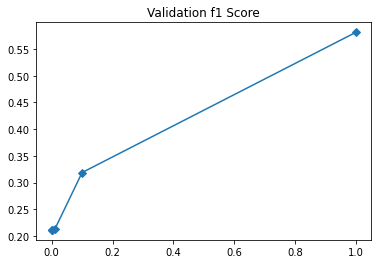

In [ ]:
plt.title("Validation f1 Score")
plt.plot(C, f1Scores, marker="D")
plt.show()

In [ ]:
print("F1 Score on Validation:", f1Scores[-1])
preds = LR.predict(testVectorizedData)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

F1 Score on Validation: 0.5812858164407344
F1 Score on Test: 0.2544874235952429


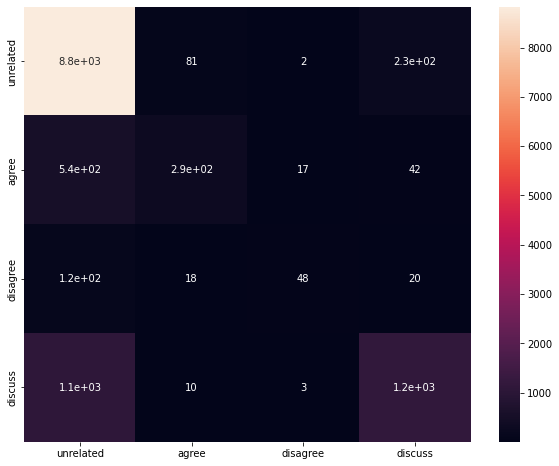

In [ ]:
cfMat = confusion_matrix(y_val, LR.predict(valVectorizedData), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

#### Word2Vec:

In [19]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
f1Scores = []
for c in C:
    if os.path.isfile("LogisticRegressionW2V" + " c:" + str(c)):
        LR = joblib.load("LogisticRegressionW2V" + " c:" + str(c))
    else:
        LR = LogisticRegression(n_jobs=4, verbose=2, C=c)
        LR.fit(w2vTrain, y_train)
        joblib.dump(LR, "LogisticRegressionW2V" + " c:" + str(c))
        
    preds = LR.predict(w2vVal)
    f1Scores.append(f1_score(y_val, preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.9s finished


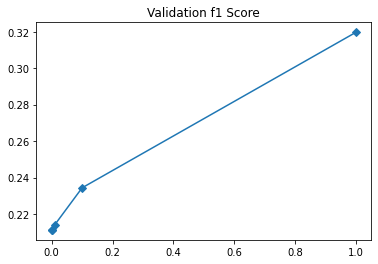

In [20]:
plt.title("Validation f1 Score")
plt.plot(C, f1Scores, marker="D")
plt.show()

In [21]:
print("F1 Score on Validation:", f1Scores[-1])
preds = LR.predict(w2vTest)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

F1 Score on Validation: 0.3197437661573422
F1 Score on Test: 0.268083676037363


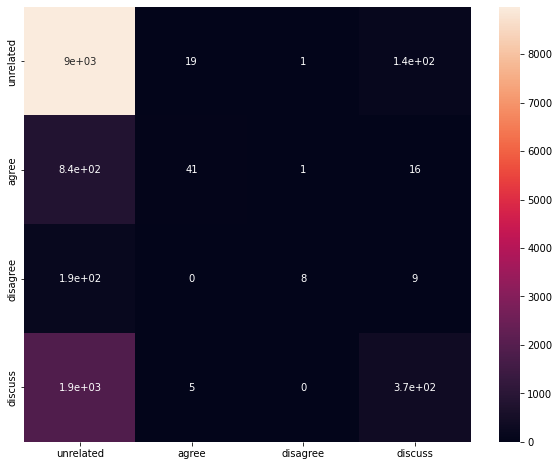

In [22]:
cfMat = confusion_matrix(y_val, LR.predict(w2vVal), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

### 2. Decision Tree Classifier:

#### TFIDF

In [ ]:
md = [3, 4, 5, 6, 7, 8, 10, 15, 25]
f1Scores = []

In [ ]:
for d in md:
    if os.path.isfile("DecisionTreeClassifierTFIDF" + str(d)):
        DT = joblib.load("DecisionTreeClassifierTFIDF" + str(d))
    else:
        DT = DecisionTreeClassifier(random_state=0, max_depth=d)
        DT.fit(trainVectorizedData, y_train)
        joblib.dump(DT, "DecisionTreeClassifierTFIDF" + str(d))
        
    preds = DT.predict(valVectorizedData)
    f1Scores.append(f1_score(y_val, preds, average='macro'))

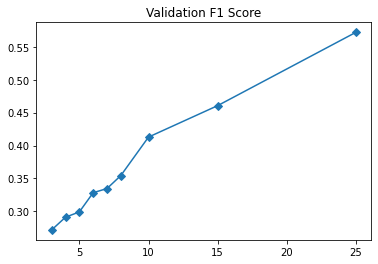

In [ ]:
plt.title("Validation F1 Score")
plt.plot(md, f1Scores, marker="D")
plt.show()

In [ ]:
print("F1 Score on Validation:", f1Scores[-1])
preds = DT.predict(testVectorizedData)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

F1 Score on Validation: 0.5723107568771763
F1 Score on Test: 0.26334436398558025


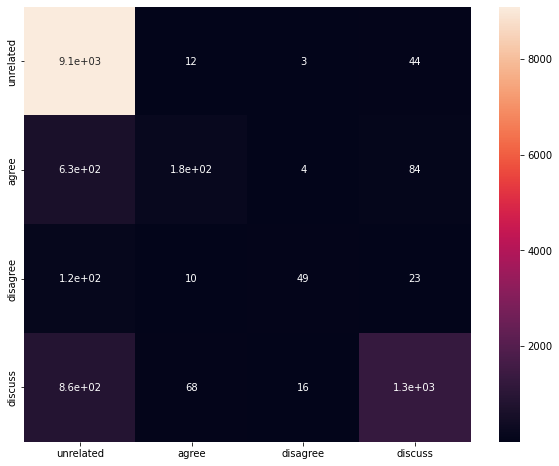

In [ ]:
cfMat = confusion_matrix(y_val, DT.predict(valVectorizedData), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

#### Word2Vec:

In [23]:
md = [3, 4, 5, 6, 7, 8, 10, 15, 25]
f1Scores = []
for d in md:
    if os.path.isfile("DecisionTreeClassifierW2V" + str(d)):
        DT = joblib.load("DecisionTreeClassifierW2V" + str(d))
    else:
        DT = DecisionTreeClassifier(random_state=0, max_depth=d)
        DT.fit(w2vTrain, y_train)
        joblib.dump(DT, "DecisionTreeClassifierW2V" + str(d))
        
    preds = DT.predict(w2vVal)
    f1Scores.append(f1_score(y_val, preds, average='macro'))

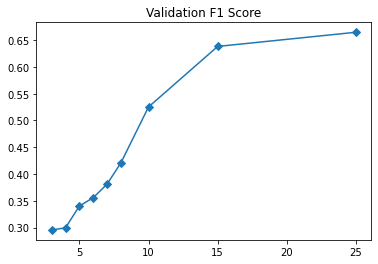

In [24]:
plt.title("Validation F1 Score")
plt.plot(md, f1Scores, marker="D")
plt.show()

In [25]:
print("F1 Score on Validation:", f1Scores[-1])
preds = DT.predict(w2vTest)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

F1 Score on Validation: 0.6648470290953956
F1 Score on Test: 0.29745851687449676


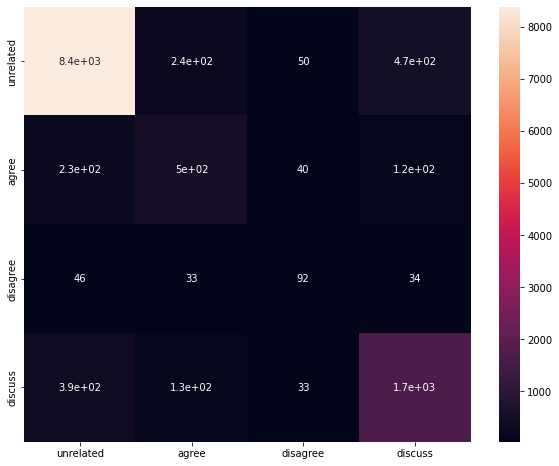

In [26]:
cfMat = confusion_matrix(y_val, DT.predict(w2vVal), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

### 3. Random Forests:

#### TFIDF

In [ ]:
estims = [50, 100, 150]
ccp_a = [0.000001, 0.00001, 0.0001, 0.001]
xlabs = []
f1Scores = []
for tr in estims:
    for cp in ccp_a:
        xlabs.append(str(tr) + str(cp))
        if os.path.isfile("RFTFIDF" + str(tr) + str(cp)):
            RF = joblib.load("RFTFIDF" + str(tr) + str(cp))
        else:
            RF = RandomForestClassifier(random_state=0, n_estimators=tr, verbose=1, n_jobs=4, ccp_alpha=cp)
            RF.fit(trainVectorizedData, y_train)
            joblib.dump(RF, "RFTFIDF" + str(tr) + str(cp))

        preds = RF.predict(valVectorizedData)
        f1Scores.append(f1_score(y_val, preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_job

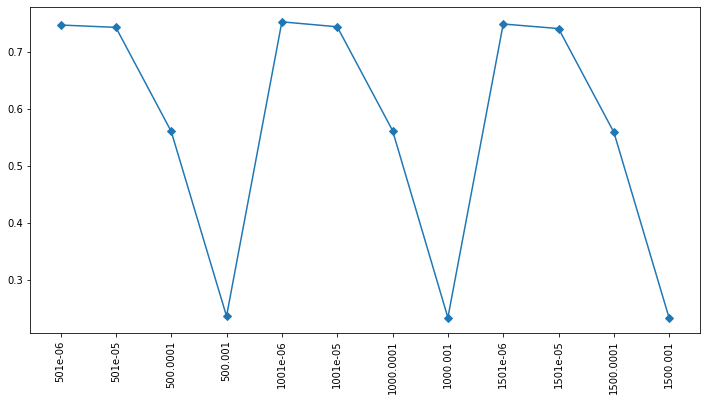

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(xlabs, f1Scores, marker="D")
plt.xticks(rotation=90)
plt.show()

In [ ]:
RF = joblib.load("RFTFIDF" + str(50) + str(0.0001))

In [ ]:
preds = RF.predict(valVectorizedData)
print("F1 Score on Validation:", f1_score(y_val, preds, average='macro'))
preds = RF.predict(testVectorizedData)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.4s finished


F1 Score on Validation: 0.5600226462489616


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.7s finished


F1 Score on Test: 0.2430693000648944


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.4s finished


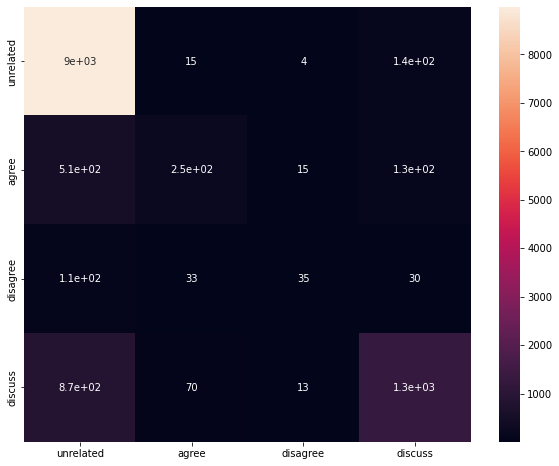

In [ ]:
cfMat = confusion_matrix(y_val, RF.predict(valVectorizedData), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

#### Word2Vec:

In [27]:
estims = [50, 100, 150]
ccp_a = [0.000001, 0.00001, 0.0001, 0.001]
xlabs = []
f1Scores = []
for tr in estims:
    for cp in ccp_a:
        xlabs.append(str(tr) + ", " + str(cp))
        if os.path.isfile("RFW2V" + str(tr) + str(cp)):
            RF = joblib.load("RFW2V" + str(tr) + str(cp))
        else:
            RF = RandomForestClassifier(random_state=0, n_estimators=tr, verbose=1, n_jobs=4, ccp_alpha=cp)
            RF.fit(w2vTrain, y_train)
            joblib.dump(RF, "RFW2V" + str(tr) + str(cp))

        preds = RF.predict(w2vVal)
        f1Scores.append(f1_score(y_val, preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   28.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   28.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_job

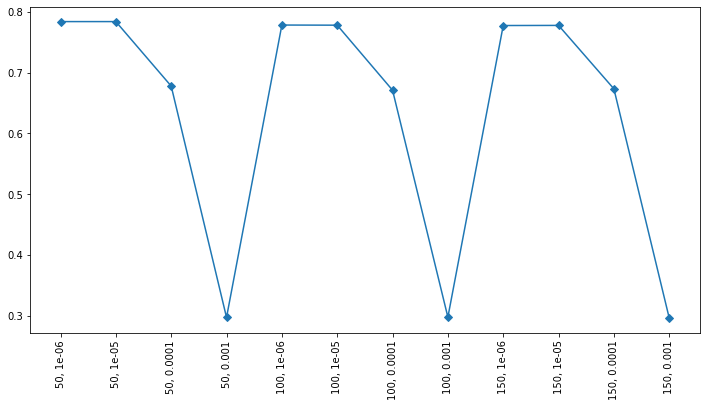

In [28]:
plt.figure(figsize=(12,6))
plt.plot(xlabs, f1Scores, marker="D")
plt.xticks(rotation=90)
plt.show()

In [29]:
RF = joblib.load("RFW2V" + str(50) + str(0.0001))

In [30]:
preds = RF.predict(w2vVal)
print("F1 Score on Validation:", f1_score(y_val, preds, average='macro'))
preds = RF.predict(w2vTest)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


F1 Score on Validation: 0.6779085203812482


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


F1 Score on Test: 0.23754376202032543


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


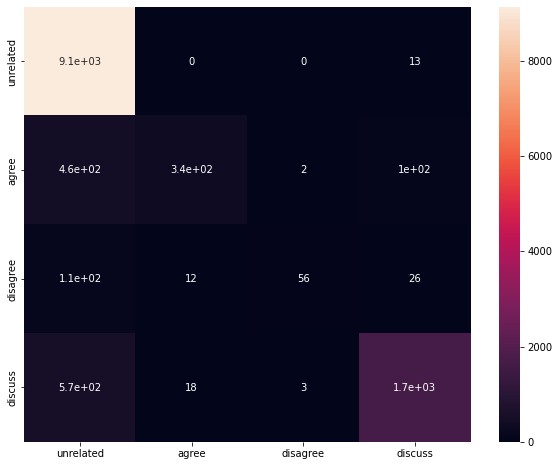

In [31]:
cfMat = confusion_matrix(y_val, RF.predict(w2vVal), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

### 4. SVC

In [ ]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
f1Scores = []

for c in C:
    if os.path.isfile("SVCTFIDF" + " c:" + str(c)):
        svc = joblib.load("SVCTFIDF" + " c:" + str(c))
    else:
        svc = SVC(verbose=2, C=c)
        svc.fit(trainVectorizedData, y_train)
        joblib.dump(svc, "SVCTFIDF" + " c:" + str(c))
        
    preds = svc.predict(valVectorizedData)
    f1Scores.append(f1_score(y_val, preds, average='macro'))


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

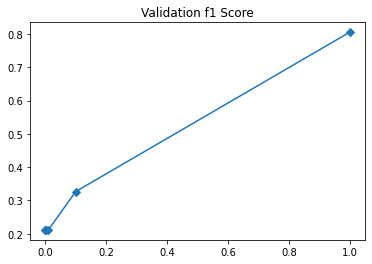

In [ ]:
plt.title("Validation f1 Score")
plt.plot(C, f1Scores, marker="D")
plt.show()

In [ ]:
print("F1 Score on Validation:", f1Scores[-1])
preds = svc.predict(testVectorizedData)
print("F1 Score on Test:", f1_score(testStances['Stance'], preds, average='macro'))

F1 Score on Validation: 0.8053079369723057
F1 Score on Test: 0.2537317147235145


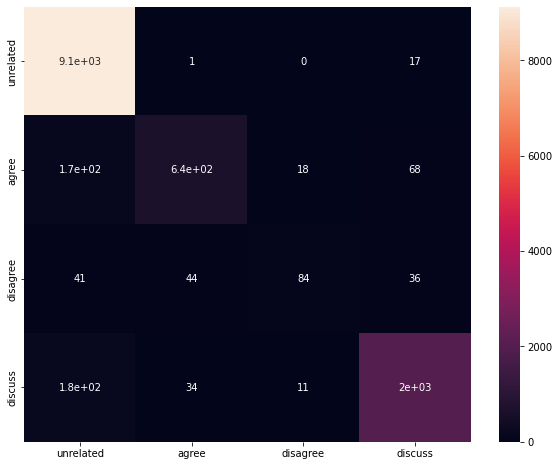

In [ ]:
cfMat = confusion_matrix(y_val, svc.predict(valVectorizedData), 
                         labels=['unrelated', 'agree', 'disagree', 'discuss'])
cfDf = pd.DataFrame(cfMat, index=['unrelated', 'agree', 'disagree', 'discuss'], 
                    columns=['unrelated', 'agree', 'disagree', 'discuss'])

plt.figure(figsize=(10,8))
sns.heatmap(cfDf, annot=True)
plt.show()

### 5. MLP

In [ ]:
tfIdfHeads = TfidfVectorizer(max_features=3000)
tfIdfHeads.fit(trainHeads)
tfIdfBodies = TfidfVectorizer(max_features=3000)
tfIdfBodies.fit(trainBodies)

TfidfVectorizer(max_features=3000)

In [ ]:
def getSimilarity(x, y):
  cos = []
  for i, _ in enumerate(x):
      cos.append([cosine_similarity([x[i]], [y[i]])[0][0]])
  return np.array(cos)


In [ ]:
vectorizedHeads = tfIdfHeads.transform(trainHeads).toarray()
vectorizedBodies = tfIdfBodies.transform(trainBodies).toarray()
cosSimil = getSimilarity(vectorizedHeads, vectorizedBodies)
trainVectorizedData = np.hstack((vectorizedHeads, vectorizedBodies, cosSimil))
del(vectorizedHeads)
del(vectorizedBodies)
del(cosSimil)

In [ ]:
vectorizedHeads = tfIdfHeads.transform(valHeads).toarray()
vectorizedBodies = tfIdfBodies.transform(valBodies).toarray()
cosSimil = getSimilarity(vectorizedHeads, vectorizedBodies)
valVectorizedData = np.hstack((vectorizedHeads, vectorizedBodies, cosSimil))
del(vectorizedHeads)
del(vectorizedBodies)
del(cosSimil)

In [ ]:
testStances = pd.read_csv('competition_test_stances.csv')
testBodies = pd.read_csv('competition_test_bodies.csv')
testHeads, testBodies = generateData(testStances, testBodies)
testHeads = [preprocessText(x) for x in testHeads]
testBodies = [preprocessText(x) for x in testBodies]
testVectorizedHeads = tfIdfHeads.transform(testHeads).toarray()
testVectorizedBodies = tfIdfBodies.transform(testBodies).toarray()
cosSimil = getSimilarity(testVectorizedHeads, testVectorizedBodies)
testVectorizedData = np.hstack((testVectorizedHeads, testVectorizedBodies, cosSimil))
del(testVectorizedHeads)
del(testVectorizedBodies)
del(testHeads)
del(testBodies)
del(cosSimil)

In [ ]:
lb = LabelEncoder()
new_y_train = lb.fit_transform(y_train)
new_y_val = lb.transform(y_val)
new_y_test = lb.transform(testStances['Stance'])

In [ ]:
new_y_train = to_categorical(new_y_train, 4)
new_y_val = to_categorical(new_y_val, 4)
new_y_test = to_categorical(new_y_test, 4)

In [ ]:
model = Sequential()
model.add(Dense(1000, input_shape=(len(trainVectorizedData[0]),), activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainVectorizedData, new_y_train, epochs=5, batch_size=128, verbose=2, validation_data=(valVectorizedData, new_y_val))

Epoch 1/5
293/293 - 17s - loss: 0.5042 - accuracy: 0.8276 - val_loss: 0.2548 - val_accuracy: 0.9199 - 17s/epoch - 59ms/step
Epoch 2/5
293/293 - 17s - loss: 0.1393 - accuracy: 0.9598 - val_loss: 0.1207 - val_accuracy: 0.9637 - 17s/epoch - 56ms/step
Epoch 3/5
293/293 - 17s - loss: 0.0571 - accuracy: 0.9839 - val_loss: 0.0897 - val_accuracy: 0.9725 - 17s/epoch - 56ms/step
Epoch 4/5
293/293 - 17s - loss: 0.0304 - accuracy: 0.9922 - val_loss: 0.0792 - val_accuracy: 0.9769 - 17s/epoch - 57ms/step
Epoch 5/5
293/293 - 17s - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.0729 - val_accuracy: 0.9781 - 17s/epoch - 57ms/step


In [ ]:
preds = model.predict(testVectorizedData)
preds = [np.argmax(x) for x in preds]

In [ ]:
f1_score(lb.transform(testStances['Stance']), preds, average='macro')

0.3812654735602503